<a href="https://colab.research.google.com/github/JanePer/AI---PORTFOLIO/blob/main/Task8(Pro)_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%B4%D0%BB%D1%8F_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B8_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE_%D0%9F%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Классификация музыкальных жанров**

**1. Импорт библиотек и загрузка базы данных**

In [ ]:
import librosa #Для параметризации аудио
import librosa.display #Для отображения аудио сигналов
import IPython.display as ipd #Для проигрывания аудио
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from google.colab import files
from google.colab import drive
%matplotlib inline

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM #Базовые слои
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint

drive.mount('/content/drive')
!rm -R '/content/audios_genres' #remove texts directory
!unzip -q '/content/drive/MyDrive/Colab Notebooks/genres.zip' -d '/content/audios_genres' #unzip to created `texts` directory

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
genres = os.listdir('audios_genres/genres')
#Проверяем выгруженные папки
!ls audios_genres/genres 
#И одну из папок
!ls audios_genres/genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [ ]:
ipd.Audio('/content/audios_genres/genres/blues.00000.au')

**2. Формирование обучающей и проверочной выборки**

In [ ]:
#Функция параметризации аудио
def get_features(y, sr):
  #Получаем различные параметры аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) #Частота цветности (по умолчанию 12 баков цветности)
  mfcc = librosa.feature.mfcc(y=y, sr=sr) #Мел кепстральные коэффициенты (по умолчанию 20)
  
  rmse = np.mean(librosa.feature.rms(y=y)) #Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) #среднее спектральныго центроида
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) #среднее ширины полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) #среднее спектрального спада частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) #среднее частота пересечения нуля звукового временного ряда
  
  
  #Добавляем все параметры в один список
  out = [] # создаем пустой список
  out.append(rmse) #  добавляем среднеквадратичную амплитуду
  out.append(spec_cent) #добавляем спектральный центроид
  out.append(spec_bw) # добавляем ширину полосы частот
  out.append(rolloff) # добавляем спектральный спад частоты
  out.append(zcr) # добавляем пересечение нуля
  
  #добавляем среднее всех Мел спектральных коэффициентов (20 значений)
  for e in mfcc:
    out.append(np.mean(e))

  #добавляем среднее всех Частот цветности (12 значений)
  for e in chroma_stft:
    out.append(np.mean(e))
  
  #Возвращаем получившийся список размерностью (37,)
  return out

In [ ]:
import time #подключаем модуль time для подсчёта времени на обработку одного жанра

#Формируем обучающую выборку
#Создаём пустые листы
X_train = []
Y_train = []

#Запоминаем время старта формирования выборки
curr_time = time.time()

#Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] #Берём текущий жанр
  #Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'/content/audios_genres/genres/{g}'):
    #Получаем имя песни
    songname = f'/content/audios_genres/genres/{g}/{filename}'
    #Загружаем в y аудиосигнал
    #Используем первые 30 секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=30) #y - массив данных временного ряда аудио, sr - частота дискретизации временного ряда
    #Превращаем сигнал в параметризованные данные
    out = get_features(y, sr)
    
    #Добавляем строку в X_train
    X_train.append(out)
    #Добавляем в Y_train номер жанра в формате ohe
    Y_train.append(to_categorical(i, len(genres)))

  #Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

#Превращаем обучающую выборку на numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр metal готов -> 37c
Жанр blues готов -> 37c
Жанр rock готов -> 37c
Жанр reggae готов -> 36c
Жанр classical готов -> 36c
Жанр hiphop готов -> 36c
Жанр disco готов -> 37c
Жанр pop готов -> 36c
Жанр country готов -> 37c
Жанр jazz готов -> 37c


In [ ]:
#Создаём backup обучающей выборки
X_train_backup = X_train.copy()
Y_train_backup = Y_train.copy()

In [ ]:
#Выводим номера классов, чтобы проверить, что всё правильно заполнилось
#И номера классов идут последовательно крупными блоками
y_train_class = np.argmax(Y_train, axis=1)
print(y_train_class)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [ ]:
#Выводим размеры обучающей выборки
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 37)
(1000, 10)
(1000,)


In [ ]:
#Создаём scaler экземпляр класса StandardScaler() для нормировки данных
scaler = StandardScaler()
#Номируем X_train
X_train = scaler.fit_transform(X_train)
#Проверяем, что X_train нормировался
print(X_train[0])

[ 0.35715255 -0.14358992 -0.34326931 -0.07726414 -0.36686636  0.44624308
  0.08256138 -0.6800256   1.60839821 -0.62491447  1.36082381 -0.45444274
  0.38704242  0.88964618  0.6930676  -0.59779877  0.70396908 -0.02180169
  0.10590097 -0.6807668  -0.48910502 -0.21153444  1.50513946 -0.72636555
 -2.13989489 -1.5641733  -1.38895273 -0.55517677  1.53226981  0.68420841
 -0.88117019 -0.88357164 -0.04171562  2.32797065  0.90094167  0.10524749
 -0.33721959]


In [ ]:
#Разделяем выборку на обучающую и проверочную
#Для проверочной используем 10% примеров
#Так как база маленькая
x_train, x_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

#Выводим размеры обучающей и проверочной выборки для проверки
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(900, 37)
(900,)
(100, 37)
(100,)


**3. Cоздаем и обучаем сеть - Простая полносвязная сеть с 1 Dense слоем**

In [ ]:
#создаем колбек для сохранения модели с наибольшим val_accuracy
model_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/best_model.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
modelD1 = Sequential()
modelD1.add(Dense(800, input_dim=37, activation='elu'))
modelD1.add(Dropout(0.2))
modelD1.add(BatchNormalization())
modelD1.add(Dense(10, activation='softmax'))

modelD1.compile(optimizer=(RMSprop(learning_rate=1e-3)), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#modelD1.summary()

In [ ]:
history = modelD1.fit(x_train, y_train, epochs=150, batch_size=20, validation_data=(x_test, y_test), verbose=0, callbacks=[model_checkpoint_callback])

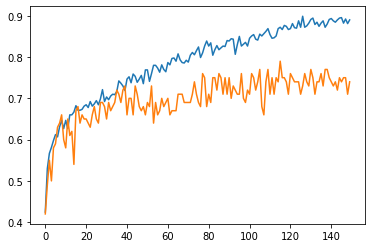

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
print('accuracy на последней эпохе: ', round(history.history["accuracy"][-1]*100))
print('val_accuracy на последней эпохе: ', round(history.history["val_accuracy"][-1]*100))
print('максимальная val_accuracy: ', round(max(history.history["val_accuracy"])*100))

accuracy на последней эпохе:  89
val_accuracy на последней эпохе:  74
максимальная val_accuracy:  79


In [ ]:
modelD1.load_weights('/content/drive/MyDrive/best_model.h5') #загружаем лучшую модель

In [ ]:
#решила попробовать еще раз дообучить на таком же learning_rate
modelD1.compile(optimizer=(RMSprop(learning_rate=1e-3)), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = modelD1.fit(x_train, y_train, epochs=150, batch_size=20, validation_data=(x_test, y_test), verbose=0, callbacks=[model_checkpoint_callback])

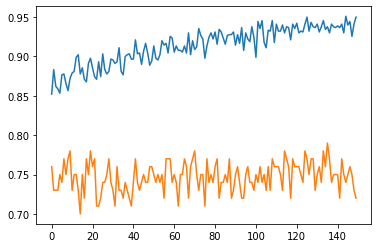

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
print('accuracy на последней эпохе: ', round(history.history["accuracy"][-1]*100))
print('val_accuracy на последней эпохе: ', round(history.history["val_accuracy"][-1]*100))
print('максимальная val_accuracy: ', round(max(history.history["val_accuracy"])*100))

accuracy на последней эпохе:  95
val_accuracy на последней эпохе:  72
максимальная val_accuracy:  79


In [ ]:
modelD1.load_weights('/content/drive/MyDrive/best_model.h5') #опять загружаем лучшую модель

In [ ]:
#пробуем дообучить на резко меньшем learning_rate
modelD1.compile(optimizer=(RMSprop(learning_rate=1e-7)), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = modelD1.fit(x_train, y_train, epochs=100, batch_size=20, validation_data=(x_test, y_test), verbose=0)

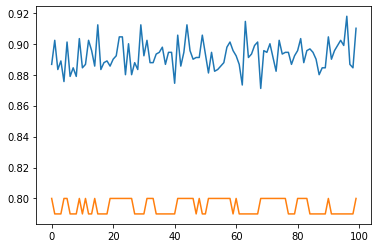

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
print('accuracy на последней эпохе: ', round(history.history["accuracy"][-1]*100))
print('val_accuracy на последней эпохе: ', round(history.history["val_accuracy"][-1]*100))
print('максимальная val_accuracy: ', round(max(history.history["val_accuracy"])*100))

accuracy на последней эпохе:  91
val_accuracy на последней эпохе:  80
максимальная val_accuracy:  80


In [ ]:
modelD1.save_weights('/content/drive/MyDrive/best_model.h5') #save the model